In [12]:
!pip install gymnasium


In [13]:
import gymnasium as gym
import numpy as np

In [14]:
env = gym.make('MountainCar-v0')
state, info = env.reset()

n_observations = env.observation_space.shape[0]
n_actions = env.action_space.n

print(n_observations)
print(n_actions)
print(state)

action = env.action_space.sample()
next_state, reward, terminated, truncated, info = env.step(action)

print(action)
print(next_state)
print(reward)

env.close()

2
3
[-0.45869765  0.        ]
1
[-0.45918134 -0.00048369]
-1.0


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [16]:
class DQN(nn.Module):
    def __init__(self, n_observations=2, n_actions=3):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(n_observations, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, n_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

policy_net = DQN(n_observations, n_actions)
target_net = DQN(n_observations, n_actions)

target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.Adam(policy_net.parameters(), lr=0.001)

In [17]:
import random
from collections import deque

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

memory = ReplayMemory(10000)

In [18]:
BATCH_SIZE = 128
GAMMA = 0.999

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return

    transitions = memory.sample(BATCH_SIZE)
    batch = list(zip(*transitions))

    state_batch = torch.cat(batch[0])
    action_batch = torch.cat(batch[1])
    reward_batch = torch.cat(batch[2])

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch[3])), dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch[3] if s is not None])

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]

    expected_state_action_values = (next_state_values.unsqueeze(1) * GAMMA) + reward_batch.unsqueeze(1)

    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values)

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [19]:
import math
import random
import torch

BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 1
EPS_END = 0.05
EPS_DECAY = 5000
TAU = 0.005
LR = 1e-4

steps_done = 0

def select_action(state, is_warmup=False):
    global steps_done
    if is_warmup:
        return torch.tensor([[env.action_space.sample()]], dtype=torch.long)

    # Epsilon Greedy
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1

    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], dtype=torch.long)

#  WARM UP PHASE
print("Starting Warm-Up...")
while len(memory) < 1000:
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
    terminated = False
    truncated = False

    while not (terminated or truncated):

        action = select_action(state, is_warmup=True)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward])

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32).unsqueeze(0)

        done = terminated or truncated
        memory.push(state, action, reward, next_state, done)

        state = next_state

        if done:
            break
print("Warm-Up Complete. Starting Training...")


#  TRAINING LOOP
num_episodes = 600
episode_durations=[]

for i_episode in range(num_episodes):
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

    for t in range(10000):
        # Normal action selection
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward])
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32).unsqueeze(0)

        memory.push(state, action, reward, next_state, done)
        state = next_state
        #Model optimization
        optimize_model()

        # Soft update of target network
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            print(f"Episode {i_episode} finished")
            break

print('Complete')
env.close()

Starting Warm-Up...
Warm-Up Complete. Starting Training...
Episode 0 finished
Episode 1 finished
Episode 2 finished
Episode 3 finished
Episode 4 finished
Episode 5 finished
Episode 6 finished
Episode 7 finished
Episode 8 finished
Episode 9 finished
Episode 10 finished
Episode 11 finished
Episode 12 finished
Episode 13 finished
Episode 14 finished
Episode 15 finished
Episode 16 finished
Episode 17 finished
Episode 18 finished
Episode 19 finished
Episode 20 finished
Episode 21 finished
Episode 22 finished
Episode 23 finished
Episode 24 finished
Episode 25 finished
Episode 26 finished
Episode 27 finished
Episode 28 finished
Episode 29 finished
Episode 30 finished
Episode 31 finished
Episode 32 finished
Episode 33 finished
Episode 34 finished
Episode 35 finished
Episode 36 finished
Episode 37 finished
Episode 38 finished
Episode 39 finished
Episode 40 finished
Episode 41 finished
Episode 42 finished
Episode 43 finished
Episode 44 finished
Episode 45 finished
Episode 46 finished
Episode 47 

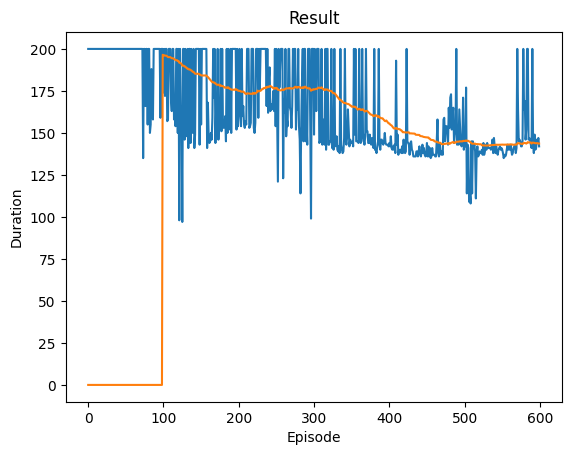

In [20]:
import matplotlib.pyplot as plt

def plot_durations(show_result=False):
    plt.figure(1)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.plot(durations_t.numpy())

    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)

plot_durations(show_result=True)
plt.show()

In [21]:
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install -u pyvirtualdisplay > /dev/null 2>&1
!pip install gymnasium[classic_control] > /dev/null 2>&1

In [22]:
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
from gymnasium.wrappers import RecordVideo

def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def wrap_env(env):
    # This wrapper records the video
    env = RecordVideo(env, './video',  episode_trigger = lambda episode_id: True)
    return env

# 1. Create a new environment for testing (with video recording)
test_env = wrap_env(gym.make("MountainCar-v0", render_mode="rgb_array"))

# 2. Run one episode using your TRAINED policy_net
state, info = test_env.reset()
state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
done = False

while not done:
    # Select the best action (No random exploration)
    with torch.no_grad():
        action = policy_net(state).max(1)[1].view(1, 1)

    observation, reward, terminated, truncated, _ = test_env.step(action.item())

    if terminated or truncated:
        done = True
    else:
        state = torch.tensor(observation, dtype=torch.float32).unsqueeze(0)

test_env.close()

# 3. Show the video
show_video()

/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
